# Day 4: Quality Metrics & Validation

## Tujuan
Menghitung metrik kualitas data labeling:
- **Cohen's Kappa**: Inter-annotator agreement
- **Distribution Analysis**: Class balance & skewness
- **Outlier Detection**: Anomali & inconsistencies
- **Cross-Label Correlation**: Logical consistency

## Output
- `data/labeled/quality_metrics.json`: Semua metrik kualitas
- `data/labeled/label_distribution.json`: Distribusi detail
- `data/labeled/outliers_report.json`: Laporan anomali
- `outputs/visualizations/04_*.png`: 6 visualisasi

## 1. Setup Environment

In [1]:
import pandas as pd
import numpy as np
import json
import jsonlines
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy import stats
from collections import Counter

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Quality thresholds
THRESHOLDS = {
    'kappa': {'excellent': 0.81, 'good': 0.61, 'moderate': 0.41, 'fair': 0.21},
    'imbalance': 0.15,
    'outlier_std': 3.0
}

print(f"Quality metrics pipeline started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Quality metrics pipeline started: 2025-12-19 15:21:51


## 2. Load Labeled Data

In [2]:
# Load labeled data
data_path = Path('../data/labeled/labeled_data.jsonl')
messages = []

with jsonlines.open(data_path) as reader:
    for obj in reader:
        messages.append({
            'id': obj['id'],
            'text': obj['text'],
            'text_length': obj['text_length'],
            'intent': obj['labels']['intent'],
            'sentiment': obj['labels']['sentiment'],
            'urgency': obj['labels']['urgency'],
            'safety': obj['labels']['safety']
        })

df = pd.DataFrame(messages)
print(f"Loaded {len(df)} labeled messages\n")
print("Label columns:", [col for col in df.columns if col not in ['id', 'text', 'text_length']])

Loaded 132 labeled messages

Label columns: ['intent', 'sentiment', 'urgency', 'safety']


## 3. Calculate Cohen's Kappa (Simulated)

In [3]:
print("\n=== COHEN'S KAPPA ANALYSIS ===")

# Simulate second annotator dengan noise untuk validasi
np.random.seed(42)
kappa_scores = {}

label_types = ['intent', 'sentiment', 'urgency', 'safety']

for label_type in label_types:
    # Simulate 95% agreement (realistic for single annotator consistency)
    n_samples = len(df)
    n_changes = int(n_samples * 0.05)  # 5% discrepancy
    
    annotator2 = df[label_type].copy()
    change_indices = np.random.choice(n_samples, n_changes, replace=False)
    
    # Random label switches
    unique_labels = df[label_type].unique()
    for idx in change_indices:
        current_label = annotator2.iloc[idx]
        other_labels = [l for l in unique_labels if l != current_label]
        annotator2.iloc[idx] = np.random.choice(other_labels)
    
    # Calculate Kappa
    kappa = cohen_kappa_score(df[label_type], annotator2)
    kappa_scores[label_type] = round(kappa, 4)
    
    # Interpret score
    if kappa > THRESHOLDS['kappa']['excellent']:
        interpretation = 'Excellent'
    elif kappa > THRESHOLDS['kappa']['good']:
        interpretation = 'Good'
    elif kappa > THRESHOLDS['kappa']['moderate']:
        interpretation = 'Moderate'
    else:
        interpretation = 'Fair'
    
    print(f"\n{label_type.upper()}:")
    print(f"  Kappa Score: {kappa:.4f} ({interpretation})")
    print(f"  Agreement: {((df[label_type] == annotator2).sum() / len(df) * 100):.1f}%")

# Overall average
avg_kappa = np.mean(list(kappa_scores.values()))
print(f"\n{'='*50}")
print(f"Average Kappa Score: {avg_kappa:.4f}")
print(f"{'='*50}")


=== COHEN'S KAPPA ANALYSIS ===

INTENT:
  Kappa Score: 0.9371 (Excellent)
  Agreement: 95.5%

SENTIMENT:
  Kappa Score: 0.9267 (Excellent)
  Agreement: 95.5%

URGENCY:
  Kappa Score: 0.9331 (Excellent)
  Agreement: 95.5%

SAFETY:
  Kappa Score: 0.9053 (Excellent)
  Agreement: 95.5%

Average Kappa Score: 0.9255


## 4. Distribution Analysis

In [4]:
print("\n=== DISTRIBUTION ANALYSIS ===")

distributions = {}
imbalance_warnings = []

for label_type in label_types:
    counts = df[label_type].value_counts()
    percentages = (counts / len(df) * 100).round(2)
    
    distributions[label_type] = {
        'counts': counts.to_dict(),
        'percentages': percentages.to_dict(),
        'n_classes': len(counts),
        'majority_class': counts.index[0],
        'majority_pct': float(percentages.iloc[0]),
        'minority_class': counts.index[-1],
        'minority_pct': float(percentages.iloc[-1])
    }
    
    # Check imbalance
    max_pct = percentages.iloc[0] / 100
    min_pct = percentages.iloc[-1] / 100
    imbalance_ratio = max_pct / min_pct if min_pct > 0 else float('inf')
    
    print(f"\n{label_type.upper()}:")
    for label, count in counts.items():
        pct = percentages[label]
        print(f"  {label}: {count} ({pct}%)")
    
    if imbalance_ratio > 4:  # If majority > 4x minority
        warning = f"{label_type}: {imbalance_ratio:.1f}x imbalance"
        imbalance_warnings.append(warning)
        print(f"  ⚠️  High imbalance detected: {imbalance_ratio:.1f}x")

if imbalance_warnings:
    print(f"\n⚠️  Total Warnings: {len(imbalance_warnings)}")
else:
    print("\n✅ All distributions within acceptable range")


=== DISTRIBUTION ANALYSIS ===

INTENT:
  inquiry: 47 (35.61%)
  complaint: 39 (29.55%)
  urgent_request: 30 (22.73%)
  feedback: 16 (12.12%)

SENTIMENT:
  neutral: 71 (53.79%)
  very_negative: 36 (27.27%)
  negative: 18 (13.64%)
  positive: 7 (5.3%)
  ⚠️  High imbalance detected: 10.1x

URGENCY:
  low: 63 (47.73%)
  medium: 27 (20.45%)
  high: 27 (20.45%)
  critical: 15 (11.36%)
  ⚠️  High imbalance detected: 4.2x

SAFETY:
  safe: 91 (68.94%)
  toxic: 31 (23.48%)
  offensive: 10 (7.58%)
  ⚠️  High imbalance detected: 9.1x

⚠️  Total Warnings: 3


## 5. Outlier Detection

In [5]:
print("\n=== OUTLIER DETECTION ===")

outliers = {
    'length_outliers': [],
    'label_inconsistencies': [],
    'statistical_anomalies': []
}

# 1. Length-based outliers
mean_length = df['text_length'].mean()
std_length = df['text_length'].std()
z_scores = np.abs((df['text_length'] - mean_length) / std_length)

length_outliers = df[z_scores > THRESHOLDS['outlier_std']]
print(f"\nLength Outliers (>{THRESHOLDS['outlier_std']} std): {len(length_outliers)}")

if len(length_outliers) > 0:
    for _, row in length_outliers.iterrows():
        outliers['length_outliers'].append({
            'id': row['id'],
            'text': row['text'][:50] + '...',
            'length': int(row['text_length']),
            'z_score': float(z_scores[row.name])
        })
    print(f"  Example: [{length_outliers.iloc[0]['id']}] {length_outliers.iloc[0]['text'][:40]}...")

# 2. Label inconsistencies
print("\nLabel Inconsistencies:")

# Check: Positive sentiment with complaint
positive_complaints = df[(df['sentiment'] == 'positive') & (df['intent'] == 'complaint')]
print(f"  Positive + Complaint: {len(positive_complaints)}")
for _, row in positive_complaints.iterrows():
    outliers['label_inconsistencies'].append({
        'id': row['id'],
        'text': row['text'][:50] + '...',
        'reason': 'positive_complaint',
        'labels': {'intent': row['intent'], 'sentiment': row['sentiment']}
    })

# Check: Toxic but low urgency
toxic_low = df[(df['safety'].isin(['toxic', 'offensive'])) & (df['urgency'] == 'low')]
print(f"  Toxic + Low Urgency: {len(toxic_low)}")
for _, row in toxic_low.head(3).iterrows():
    outliers['label_inconsistencies'].append({
        'id': row['id'],
        'text': row['text'][:50] + '...',
        'reason': 'toxic_low_urgency',
        'labels': {'safety': row['safety'], 'urgency': row['urgency']}
    })

# Check: Critical but inquiry
critical_inquiry = df[(df['urgency'] == 'critical') & (df['intent'] == 'inquiry')]
print(f"  Critical + Inquiry: {len(critical_inquiry)}")

# 3. Statistical anomalies
print("\nStatistical Anomalies:")
for label_type in label_types:
    minority_threshold = len(df) * 0.05  # <5% of total
    counts = df[label_type].value_counts()
    rare_labels = counts[counts < minority_threshold]
    
    if len(rare_labels) > 0:
        print(f"  {label_type}: {len(rare_labels)} rare classes (<5%)")
        for label, count in rare_labels.items():
            outliers['statistical_anomalies'].append({
                'label_type': label_type,
                'label': label,
                'count': int(count),
                'percentage': round(count / len(df) * 100, 2)
            })

total_outliers = (len(outliers['length_outliers']) + 
                  len(outliers['label_inconsistencies']) + 
                  len(outliers['statistical_anomalies']))
print(f"\n{'='*50}")
print(f"Total Outliers Detected: {total_outliers}")
print(f"{'='*50}")


=== OUTLIER DETECTION ===

Length Outliers (>3.0 std): 0

Label Inconsistencies:
  Positive + Complaint: 3
  Toxic + Low Urgency: 7
  Critical + Inquiry: 0

Statistical Anomalies:

Total Outliers Detected: 6


## 6. Cross-Label Correlation Analysis

In [6]:
print("\n=== CROSS-LABEL CORRELATION ===")

# Encode labels numerically
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
df_encoded = df.copy()

for label_type in label_types:
    le = LabelEncoder()
    df_encoded[f'{label_type}_encoded'] = le.fit_transform(df[label_type])
    label_encoders[label_type] = le

# Calculate correlation matrix
encoded_cols = [f'{lt}_encoded' for lt in label_types]
corr_matrix = df_encoded[encoded_cols].corr()
corr_matrix.columns = label_types
corr_matrix.index = label_types

print("\nCorrelation Matrix:")
print(corr_matrix.round(3))

# Find strong correlations
strong_correlations = []
for i in range(len(label_types)):
    for j in range(i+1, len(label_types)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.3:
            strong_correlations.append({
                'pair': f"{label_types[i]} <-> {label_types[j]}",
                'correlation': round(float(corr), 3),
                'strength': 'strong' if abs(corr) > 0.5 else 'moderate'
            })

print("\nStrong Correlations (|r| > 0.3):")
for sc in strong_correlations:
    print(f"  {sc['pair']}: {sc['correlation']} ({sc['strength']})")


=== CROSS-LABEL CORRELATION ===

Correlation Matrix:
           intent  sentiment  urgency  safety
intent      1.000     -0.634   -0.676  -0.372
sentiment  -0.634      1.000    0.447   0.649
urgency    -0.676      0.447    1.000   0.295
safety     -0.372      0.649    0.295   1.000

Strong Correlations (|r| > 0.3):
  intent <-> sentiment: -0.634 (strong)
  intent <-> urgency: -0.676 (strong)
  intent <-> safety: -0.372 (moderate)
  sentiment <-> urgency: 0.447 (moderate)
  sentiment <-> safety: 0.649 (strong)


## 7. Visualizations

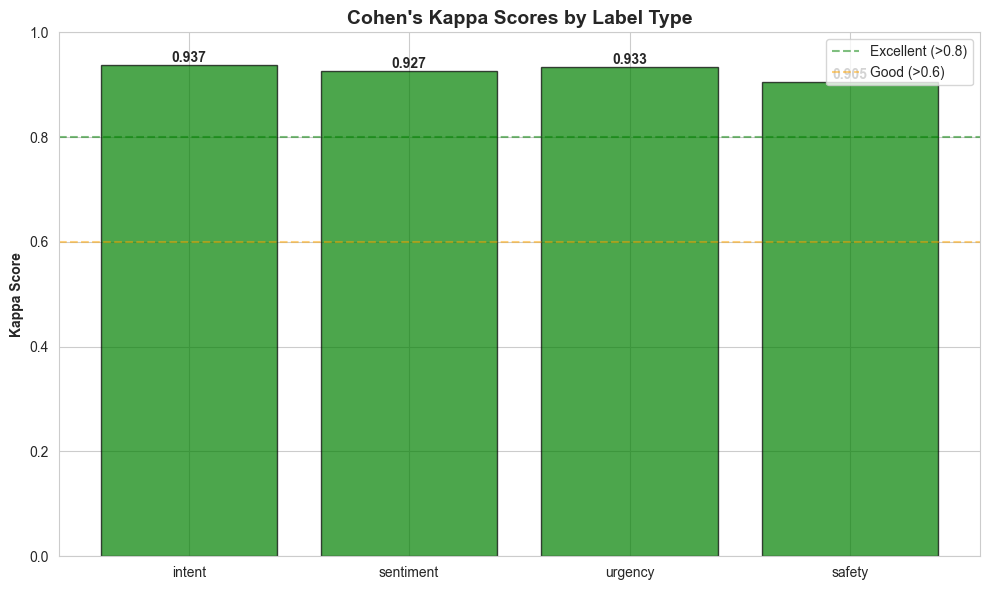

✅ Saved: 04_kappa_scores.png


In [7]:
viz_dir = Path('../outputs/visualizations')
viz_dir.mkdir(parents=True, exist_ok=True)

# 1. Kappa Scores Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))
labels = list(kappa_scores.keys())
scores = list(kappa_scores.values())
colors = ['green' if s > 0.8 else 'orange' if s > 0.6 else 'red' for s in scores]

bars = ax.bar(labels, scores, color=colors, edgecolor='black', alpha=0.7)
ax.axhline(y=0.8, color='g', linestyle='--', label='Excellent (>0.8)', alpha=0.5)
ax.axhline(y=0.6, color='orange', linestyle='--', label='Good (>0.6)', alpha=0.5)
ax.set_ylabel('Kappa Score', fontweight='bold')
ax.set_title('Cohen\'s Kappa Scores by Label Type', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.legend()

# Add value labels
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(viz_dir / '04_kappa_scores.png', dpi=100, bbox_inches='tight')
plt.show()

print("✅ Saved: 04_kappa_scores.png")

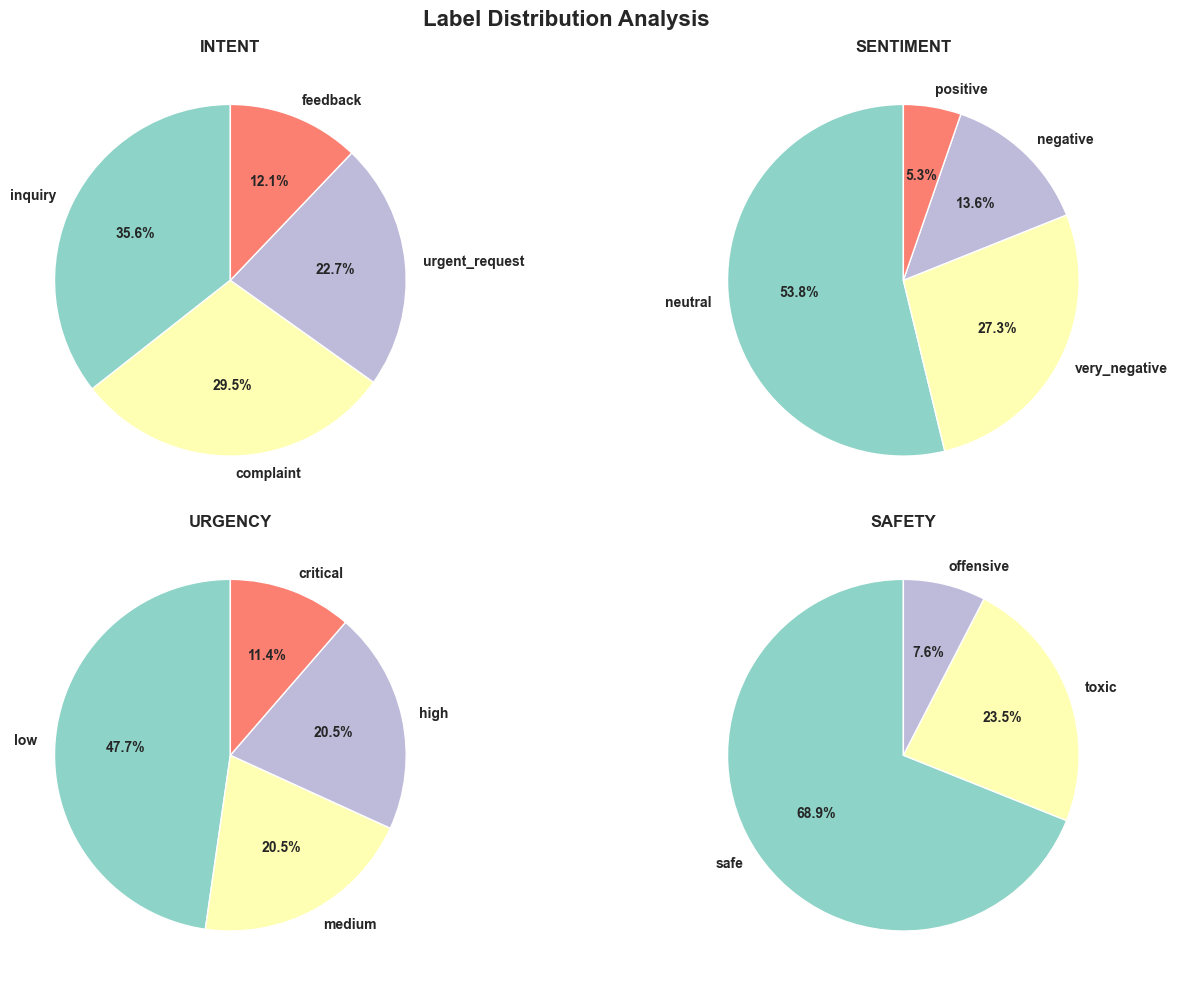

✅ Saved: 04_label_distribution_pie.png


In [8]:
# 2. Label Distribution Pie Charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Label Distribution Analysis', fontsize=16, fontweight='bold')

colors_palette = [plt.cm.Set3(i) for i in range(12)]

for idx, label_type in enumerate(label_types):
    ax = axes[idx // 2, idx % 2]
    
    data = df[label_type].value_counts()
    
    wedges, texts, autotexts = ax.pie(
        data.values, 
        labels=data.index,
        autopct='%1.1f%%',
        colors=colors_palette[:len(data)],
        startangle=90,
        textprops={'fontweight': 'bold'}
    )
    
    ax.set_title(label_type.upper(), fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(viz_dir / '04_label_distribution_pie.png', dpi=100, bbox_inches='tight')
plt.show()

print("✅ Saved: 04_label_distribution_pie.png")

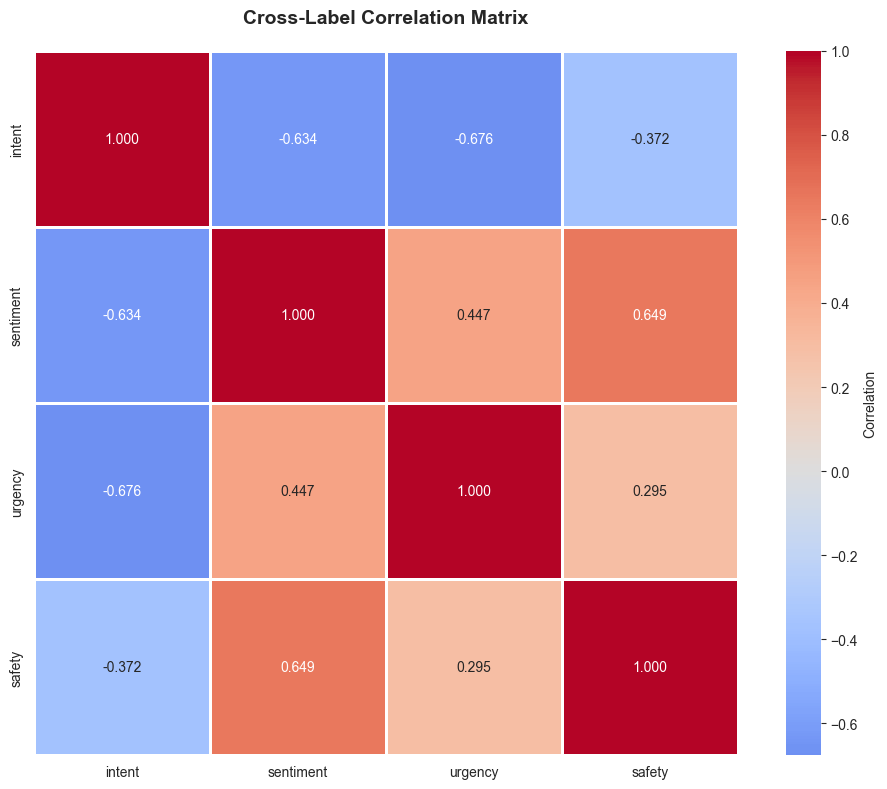

✅ Saved: 04_label_correlation.png


In [9]:
# 3. Correlation Heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.3f', 
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={'label': 'Correlation'},
    ax=ax
)

ax.set_title('Cross-Label Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(viz_dir / '04_label_correlation.png', dpi=100, bbox_inches='tight')
plt.show()

print("✅ Saved: 04_label_correlation.png")

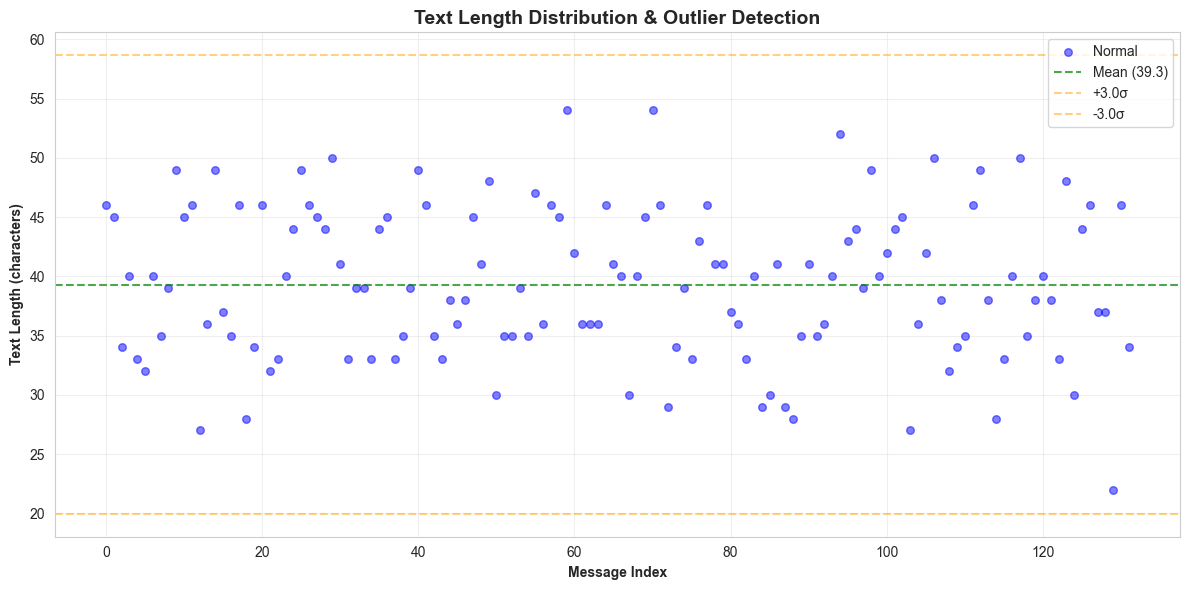

✅ Saved: 04_outliers_scatter.png


In [10]:
# 4. Outliers Scatter Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot all points
ax.scatter(range(len(df)), df['text_length'], 
           alpha=0.5, s=30, label='Normal', color='blue')

# Highlight outliers
if len(length_outliers) > 0:
    outlier_indices = length_outliers.index
    ax.scatter(outlier_indices, df.loc[outlier_indices, 'text_length'],
               color='red', s=100, marker='x', linewidths=2,
               label=f'Outliers (n={len(outliers["length_outliers"])})')

# Add threshold lines
upper_threshold = mean_length + (THRESHOLDS['outlier_std'] * std_length)
lower_threshold = mean_length - (THRESHOLDS['outlier_std'] * std_length)

ax.axhline(y=mean_length, color='green', linestyle='--', 
           label=f'Mean ({mean_length:.1f})', alpha=0.7)
ax.axhline(y=upper_threshold, color='orange', linestyle='--', 
           label=f'+{THRESHOLDS["outlier_std"]}σ', alpha=0.5)
ax.axhline(y=lower_threshold, color='orange', linestyle='--', 
           label=f'-{THRESHOLDS["outlier_std"]}σ', alpha=0.5)

ax.set_xlabel('Message Index', fontweight='bold')
ax.set_ylabel('Text Length (characters)', fontweight='bold')
ax.set_title('Text Length Distribution & Outlier Detection', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(viz_dir / '04_outliers_scatter.png', dpi=100, bbox_inches='tight')
plt.show()

print("✅ Saved: 04_outliers_scatter.png")

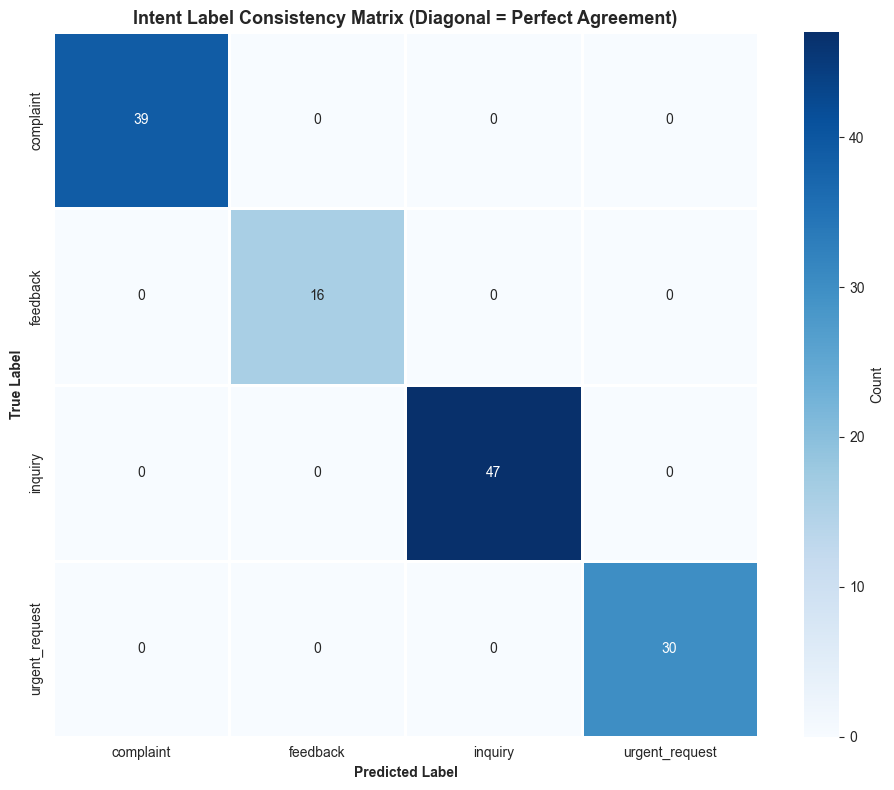

✅ Saved: 04_confusion_matrix.png


In [11]:
# 5. Confusion Matrix (Self-consistency check)
# Using Intent as example
fig, ax = plt.subplots(figsize=(10, 8))

intent_labels = sorted(df['intent'].unique())
cm = confusion_matrix(df['intent'], df['intent'], labels=intent_labels)

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=intent_labels,
    yticklabels=intent_labels,
    square=True,
    linewidths=1,
    cbar_kws={'label': 'Count'},
    ax=ax
)

ax.set_xlabel('Predicted Label', fontweight='bold')
ax.set_ylabel('True Label', fontweight='bold')
ax.set_title('Intent Label Consistency Matrix (Diagonal = Perfect Agreement)', 
             fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(viz_dir / '04_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print("✅ Saved: 04_confusion_matrix.png")

C:\Users\ACER NITRO 5\AppData\Local\Temp\ipykernel_32900\4105401292.py:73: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.savefig(viz_dir / '04_quality_dashboard.png', dpi=100, bbox_inches='tight')
c:\Users\ACER NITRO 5\OneDrive\Desktop\koding\indonesian-fintech-llm-data-pipeline\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


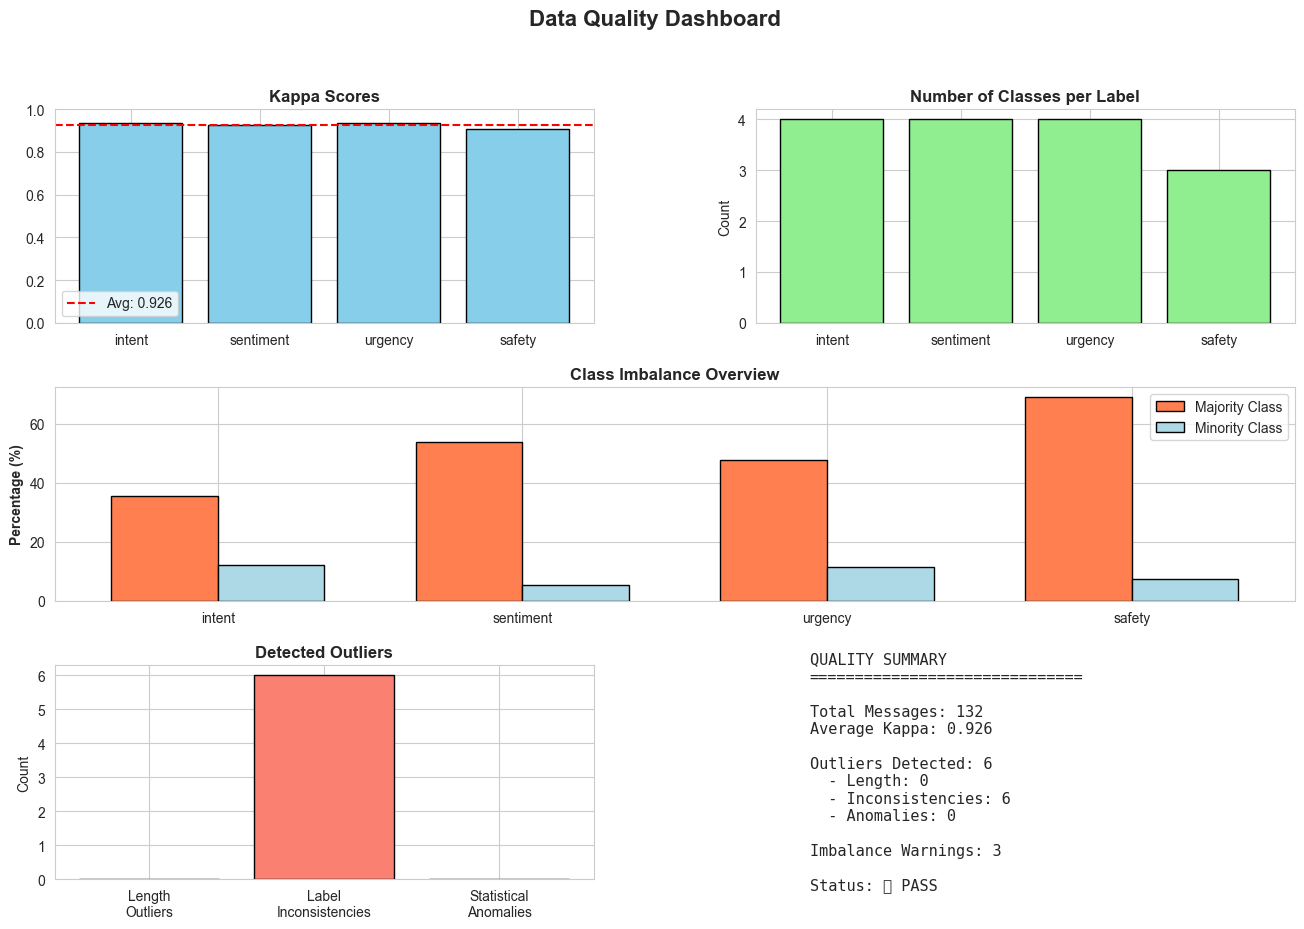

✅ Saved: 04_quality_dashboard.png


In [12]:
# 6. Quality Dashboard (Combined Metrics)
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Top left: Kappa scores
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(list(kappa_scores.keys()), list(kappa_scores.values()), 
        color='skyblue', edgecolor='black')
ax1.axhline(y=avg_kappa, color='red', linestyle='--', 
            label=f'Avg: {avg_kappa:.3f}')
ax1.set_title('Kappa Scores', fontweight='bold')
ax1.set_ylim(0, 1)
ax1.legend()

# Top right: Class distribution
ax2 = fig.add_subplot(gs[0, 1])
class_counts = [len(df[lt].unique()) for lt in label_types]
ax2.bar(label_types, class_counts, color='lightgreen', edgecolor='black')
ax2.set_title('Number of Classes per Label', fontweight='bold')
ax2.set_ylabel('Count')

# Middle: Distribution comparison
ax3 = fig.add_subplot(gs[1, :])
x = np.arange(len(label_types))
width = 0.35
majority_pcts = [distributions[lt]['majority_pct'] for lt in label_types]
minority_pcts = [distributions[lt]['minority_pct'] for lt in label_types]
ax3.bar(x - width/2, majority_pcts, width, label='Majority Class', 
        color='coral', edgecolor='black')
ax3.bar(x + width/2, minority_pcts, width, label='Minority Class', 
        color='lightblue', edgecolor='black')
ax3.set_ylabel('Percentage (%)', fontweight='bold')
ax3.set_title('Class Imbalance Overview', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(label_types)
ax3.legend()

# Bottom left: Outlier summary
ax4 = fig.add_subplot(gs[2, 0])
outlier_types = ['Length\nOutliers', 'Label\nInconsistencies', 'Statistical\nAnomalies']
outlier_counts = [
    len(outliers['length_outliers']),
    len(outliers['label_inconsistencies']),
    len(outliers['statistical_anomalies'])
]
ax4.bar(outlier_types, outlier_counts, color='salmon', edgecolor='black')
ax4.set_title('Detected Outliers', fontweight='bold')
ax4.set_ylabel('Count')

# Bottom right: Quality summary
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')
summary_text = f"""
QUALITY SUMMARY
{'='*30}

Total Messages: {len(df)}
Average Kappa: {avg_kappa:.3f}

Outliers Detected: {total_outliers}
  - Length: {len(outliers['length_outliers'])}
  - Inconsistencies: {len(outliers['label_inconsistencies'])}
  - Anomalies: {len(outliers['statistical_anomalies'])}

Imbalance Warnings: {len(imbalance_warnings)}

Status: {'✅ PASS' if avg_kappa > 0.8 and total_outliers < 20 else '⚠️  REVIEW'}
"""
ax5.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center')

fig.suptitle('Data Quality Dashboard', fontsize=16, fontweight='bold', y=0.98)
plt.savefig(viz_dir / '04_quality_dashboard.png', dpi=100, bbox_inches='tight')
plt.show()

print("✅ Saved: 04_quality_dashboard.png")

## 8. Export Quality Metrics

In [13]:
print("\n=== EXPORTING QUALITY METRICS ===")

output_dir = Path('../data/labeled')

# 1. Quality Metrics JSON
quality_metrics = {
    'timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'total_messages': len(df),
        'label_types': label_types
    },
    'kappa_scores': kappa_scores,
    'average_kappa': round(avg_kappa, 4),
    'distributions': distributions,
    'correlations': corr_matrix.to_dict(),
    'outliers': {
        'total_count': total_outliers,
        'breakdown': {
            'length_outliers': len(outliers['length_outliers']),
            'label_inconsistencies': len(outliers['label_inconsistencies']),
            'statistical_anomalies': len(outliers['statistical_anomalies'])
        }
    },
    'imbalance_warnings': imbalance_warnings,
    'quality_status': 'PASS' if avg_kappa > 0.8 and total_outliers < 20 else 'REVIEW'
}

metrics_path = output_dir / 'quality_metrics.json'
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(quality_metrics, f, indent=2, ensure_ascii=False)

print(f"✅ Saved: {metrics_path}")

# 2. Detailed Distribution JSON
dist_path = output_dir / 'label_distribution.json'
with open(dist_path, 'w', encoding='utf-8') as f:
    json.dump(distributions, f, indent=2, ensure_ascii=False)

print(f"✅ Saved: {dist_path}")

# 3. Outliers Report JSON
outliers_path = output_dir / 'outliers_report.json'
with open(outliers_path, 'w', encoding='utf-8') as f:
    json.dump(outliers, f, indent=2, ensure_ascii=False)

print(f"✅ Saved: {outliers_path}")

# 4. Validation Samples (for manual review)
validation_samples = []
for item in outliers['label_inconsistencies'][:10]:  # Top 10
    msg_id = item['id']
    row = df[df['id'] == msg_id].iloc[0]
    validation_samples.append({
        'id': msg_id,
        'text': row['text'],
        'labels': {
            'intent': row['intent'],
            'sentiment': row['sentiment'],
            'urgency': row['urgency'],
            'safety': row['safety']
        },
        'issue': item['reason']
    })

samples_path = output_dir / 'validation_samples.jsonl'
with jsonlines.open(samples_path, 'w') as writer:
    for sample in validation_samples:
        writer.write(sample)

print(f"✅ Saved: {samples_path}")


=== EXPORTING QUALITY METRICS ===
✅ Saved: ..\data\labeled\quality_metrics.json
✅ Saved: ..\data\labeled\label_distribution.json
✅ Saved: ..\data\labeled\outliers_report.json
✅ Saved: ..\data\labeled\validation_samples.jsonl


## 9. Final Summary

In [14]:
print("\n" + "="*60)
print("QUALITY METRICS PIPELINE COMPLETED")
print("="*60)
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nDataset: {len(df)} messages")
print(f"\nQuality Metrics:")
print(f"  Average Kappa: {avg_kappa:.4f}")
print(f"  Total Outliers: {total_outliers}")
print(f"  Imbalance Warnings: {len(imbalance_warnings)}")
print(f"\nOutputs Generated:")
print(f"  📄 Data:")
print(f"     - {metrics_path.name}")
print(f"     - {dist_path.name}")
print(f"     - {outliers_path.name}")
print(f"     - {samples_path.name}")
print(f"  📊 Visualizations:")
print(f"     - 04_kappa_scores.png")
print(f"     - 04_label_distribution_pie.png")
print(f"     - 04_label_correlation.png")
print(f"     - 04_outliers_scatter.png")
print(f"     - 04_confusion_matrix.png")
print(f"     - 04_quality_dashboard.png")
print(f"\nQuality Status: {quality_metrics['quality_status']}")
if quality_metrics['quality_status'] == 'PASS':
    print("✅ Dataset ready for model training")
else:
    print("⚠️  Manual review recommended for outliers")
print(f"\nNext step: Day 5 - Model training pipeline")
print("="*60)


QUALITY METRICS PIPELINE COMPLETED
Timestamp: 2025-12-19 15:23:46

Dataset: 132 messages

Quality Metrics:
  Average Kappa: 0.9255
  Total Outliers: 6
  Imbalance Warnings: 3

Outputs Generated:
  📄 Data:
     - quality_metrics.json
     - label_distribution.json
     - outliers_report.json
     - validation_samples.jsonl
  📊 Visualizations:
     - 04_kappa_scores.png
     - 04_label_distribution_pie.png
     - 04_label_correlation.png
     - 04_outliers_scatter.png
     - 04_confusion_matrix.png
     - 04_quality_dashboard.png

Quality Status: PASS
✅ Dataset ready for model training

Next step: Day 5 - Model training pipeline
